In [1]:
# First import SparkSession
from pyspark.sql import SparkSession

# Then create the Spark session
spark = SparkSession.builder \
    .appName("TweetAnalysis") \
    .config("spark.hadoop.io.compression.codecs", "org.apache.hadoop.io.compress.GzipCodec") \
    .getOrCreate()

# Now you can use Spark
print("Spark session created successfully")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/02 18:42:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark session created successfully


In [2]:
spark = SparkSession.builder \
    .config("spark.hadoop.io.compression.codecs", "org.apache.hadoop.io.compress.GzipCodec") \
    .getOrCreate()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("TweetAnalysis").getOrCreate()
df = spark.read.csv("hdfs://master-node:9000/user/dinesh/tweets_data_sample/bda_train.csv", header=True, inferSchema=True)
#print(df)
df.show(5)

+---+-------+--------+--------------------+------+
| id|keyword|location|                text|target|
+---+-------+--------+--------------------+------+
|  1|   NULL|    NULL|Our Deeds are the...|     1|
|  4|   NULL|    NULL|Forest fire near ...|     1|
|  5|   NULL|    NULL|All residents ask...|     1|
|  6|   NULL|    NULL|13,000 people rec...|     1|
|  7|   NULL|    NULL|Just got sent thi...|     1|
+---+-------+--------+--------------------+------+
only showing top 5 rows



In [2]:
print("Dinesh")

Dinesh


In [3]:
import emoji
import pandas as pd

#Text processing libraries
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#sklearn
from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

#Libraries for plotting
import seaborn as sns

#Modules for plotting
from matplotlib import pyplot as plt
import geopandas as gpd
from shapely.geometry import Point , Polygon
import descartes
from wordcloud import WordCloud, STOPWORDS

#Import Nominatim for transform city names in coords
from geopy.geocoders import Nominatim

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/surendra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import re
import string

# Register your cleaning functions as UDFs (User Defined Functions)
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove links,
    remove punctuation and remove words containing numbers.'''
    if text is None:
        return None
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

clean_text_udf = udf(clean_text, StringType())

def deEmojify(text):
    if text is None:
        return None
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', text)

deEmojify_udf = udf(deEmojify, StringType())

# Apply the cleaning functions using withColumn
df = df.withColumn('text', clean_text_udf(df['text']))
df = df.withColumn('text', deEmojify_udf(df['text']))

# For the location column (commented out in your original code)
# df = df.withColumn('location', deEmojify_udf(df['location']))

# Show the results
df.show()

[Stage 3:>                                                          (0 + 1) / 1]

+---+-------+--------+--------------------+------+
| id|keyword|location|                text|target|
+---+-------+--------+--------------------+------+
|  1|   NULL|    NULL|our deeds are the...|     1|
|  4|   NULL|    NULL|forest fire near ...|     1|
|  5|   NULL|    NULL|all residents ask...|     1|
|  6|   NULL|    NULL| people receive w...|     1|
|  7|   NULL|    NULL|just got sent thi...|     1|
|  8|   NULL|    NULL|rockyfire update ...|     1|
| 10|   NULL|    NULL|flood disaster he...|     1|
| 13|   NULL|    NULL|im on top of the ...|     1|
| 14|   NULL|    NULL|theres an emergen...|     1|
| 15|   NULL|    NULL|im afraid that th...|     1|
| 16|   NULL|    NULL|three people died...|     1|
| 17|   NULL|    NULL|haha south tampa ...|     1|
| 18|   NULL|    NULL|raining flooding ...|     1|
| 19|   NULL|    NULL|flood in bago mya...|     1|
| 20|   NULL|    NULL|damage to school ...|     1|
| 23|   NULL|    NULL|        whats up man|     0|
| 24|   NULL|    NULL|       i 

In [5]:
from pyspark.sql.functions import count, countDistinct, desc

# Calculate the metrics
keyword_stats = df.agg(
    count('keyword').alias('count'),
    countDistinct('keyword').alias('unique')
).collect()[0]

# Find the most frequent keyword and its count
top_keyword_df = df.groupBy('keyword').agg(count('*').alias('freq')) \
                  .orderBy(desc('freq')).limit(1).collect()[0]

# Print the results in the format you want
print(f"count            {keyword_stats['count']}")
print(f"unique           {keyword_stats['unique']}")
print(f"top      {top_keyword_df['keyword']}")
print(f"freq            {top_keyword_df['freq']}")
print("Name: keyword, dtype: object")

count            7987
unique           223
top      None
freq            400
Name: keyword, dtype: object


In [6]:
# Get unique non-null keywords and sort
unique_keywords = df.select('keyword').na.drop().distinct().rdd.flatMap(lambda x: x).collect()
unique_keywords_sorted = sorted(unique_keywords)
unique_keywords_sorted

['0',
 '1',
 'ablaze',
 'accident',
 'aftershock',
 'airplane%20accident',
 'ambulance',
 'annihilated',
 'annihilation',
 'apocalypse',
 'armageddon',
 'army',
 'arson',
 'arsonist',
 'attack',
 'attacked',
 'avalanche',
 'battle',
 'bioterror',
 'bioterrorism',
 'blaze',
 'blazing',
 'bleeding',
 'blew%20up',
 'blight',
 'blizzard',
 'blood',
 'bloody',
 'blown%20up',
 'body%20bag',
 'body%20bagging',
 'body%20bags',
 'bomb',
 'bombed',
 'bombing',
 'bridge%20collapse',
 'buildings%20burning',
 'buildings%20on%20fire',
 'burned',
 'burning',
 'burning%20buildings',
 'bush%20fires',
 'casualties',
 'casualty',
 'catastrophe',
 'catastrophic',
 'chemical%20emergency',
 'cliff%20fall',
 'collapse',
 'collapsed',
 'collide',
 'collided',
 'collision',
 'crash',
 'crashed',
 'crush',
 'crushed',
 'curfew',
 'cyclone',
 'damage',
 'danger',
 'dead',
 'death',
 'deaths',
 'debris',
 'deluge',
 'deluged',
 'demolish',
 'demolished',
 'demolition',
 'derail',
 'derailed',
 'derailment',
 'des

In [6]:
from pyspark.sql.functions import col, regexp_replace
from pyspark.sql.types import StringType

# 1. Replace "%20" with spaces in the keyword column
df = df.withColumn('keyword', regexp_replace(col('keyword'), '%20', ' '))

# 2. Cast to string type (though PySpark columns are already StringType by default for text)
df = df.withColumn('keyword', col('keyword').cast(StringType()))

# 3. Get all unique values (with null handling)
unique_keywords = (df.select('keyword')
                  .na.drop()  # Remove nulls
                  .distinct()
                  .rdd.flatMap(lambda x: x)
                  .collect())
unique_keywords_sorted = sorted([k for k in unique_keywords if k is not None])

# Show results
unique_keywords_sorted

['0',
 '1',
 'ablaze',
 'accident',
 'aftershock',
 'airplane accident',
 'ambulance',
 'annihilated',
 'annihilation',
 'apocalypse',
 'armageddon',
 'army',
 'arson',
 'arsonist',
 'attack',
 'attacked',
 'avalanche',
 'battle',
 'bioterror',
 'bioterrorism',
 'blaze',
 'blazing',
 'bleeding',
 'blew up',
 'blight',
 'blizzard',
 'blood',
 'bloody',
 'blown up',
 'body bag',
 'body bagging',
 'body bags',
 'bomb',
 'bombed',
 'bombing',
 'bridge collapse',
 'buildings burning',
 'buildings on fire',
 'burned',
 'burning',
 'burning buildings',
 'bush fires',
 'casualties',
 'casualty',
 'catastrophe',
 'catastrophic',
 'chemical emergency',
 'cliff fall',
 'collapse',
 'collapsed',
 'collide',
 'collided',
 'collision',
 'crash',
 'crashed',
 'crush',
 'crushed',
 'curfew',
 'cyclone',
 'damage',
 'danger',
 'dead',
 'death',
 'deaths',
 'debris',
 'deluge',
 'deluged',
 'demolish',
 'demolished',
 'demolition',
 'derail',
 'derailed',
 'derailment',
 'desolate',
 'desolation',
 'des

In [7]:
print("Dinesh")

Dinesh


In [7]:
from pyspark.sql.functions import col, lit, concat, when

# Add quotes around location values with proper null handling
df = df.withColumn("location",
                  when(col("location").isNull(), lit("''"))
                  .otherwise(concat(lit("'"), col("location"), lit("'"))))

# Show the result
df.show()

+---+-------+--------+--------------------+------+
| id|keyword|location|                text|target|
+---+-------+--------+--------------------+------+
|  1|   NULL|      ''|our deeds are the...|     1|
|  4|   NULL|      ''|forest fire near ...|     1|
|  5|   NULL|      ''|all residents ask...|     1|
|  6|   NULL|      ''| people receive w...|     1|
|  7|   NULL|      ''|just got sent thi...|     1|
|  8|   NULL|      ''|rockyfire update ...|     1|
| 10|   NULL|      ''|flood disaster he...|     1|
| 13|   NULL|      ''|im on top of the ...|     1|
| 14|   NULL|      ''|theres an emergen...|     1|
| 15|   NULL|      ''|im afraid that th...|     1|
| 16|   NULL|      ''|three people died...|     1|
| 17|   NULL|      ''|haha south tampa ...|     1|
| 18|   NULL|      ''|raining flooding ...|     1|
| 19|   NULL|      ''|flood in bago mya...|     1|
| 20|   NULL|      ''|damage to school ...|     1|
| 23|   NULL|      ''|        whats up man|     0|
| 24|   NULL|      ''|       i 

In [8]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
import emoji

# Define the UDF version of your function
def emojiflag_to_text(flag):
    '''Convert the emoji flag to a string with their name'''
    if flag is not None and len(flag) == 4:  # Added null check
        try:
            return emoji.demojize(flag)
        except:
            return flag
    return flag

# Register the UDF
emoji_udf = udf(emojiflag_to_text, StringType())

# Apply the transformation
df = df.withColumn('location', emoji_udf(col('location')))

# Show results (first 20 rows)
df.select('location').show(20, truncate=False)

+--------+
|location|
+--------+
|''      |
|''      |
|''      |
|''      |
|''      |
|''      |
|''      |
|''      |
|''      |
|''      |
|''      |
|''      |
|''      |
|''      |
|''      |
|''      |
|''      |
|''      |
|''      |
|''      |
+--------+
only showing top 20 rows



In [8]:
from pyspark.sql.functions import col, regexp_replace, when, udf
from pyspark.sql.types import StringType
import re

# 1. Remove single quotes
df = df.withColumn('location', regexp_replace(col('location'), "'", ""))

# 2. Remove colons
df = df.withColumn('location', regexp_replace(col('location'), ":", ""))

# 3. Replace "nan" strings with actual nulls
df = df.withColumn('location', 
                  when(col('location') == 'nan', None)
                  .otherwise(col('location')))

# 4. Remove remaining emojis using UDF
def remove_special_chars(text):
    if text is None:
        return None
    return re.sub(r'[^\w\s#@/:%.,_-]', '', text)

remove_chars_udf = udf(remove_special_chars, StringType())
df = df.withColumn('location', remove_chars_udf(col('location')))

# Show cleaned results (first 20 rows without truncation)
df.select('location').show(20, truncate=False)

+--------+
|location|
+--------+
|        |
|        |
|        |
|        |
|        |
|        |
|        |
|        |
|        |
|        |
|        |
|        |
|        |
|        |
|        |
|        |
|        |
|        |
|        |
|        |
+--------+
only showing top 20 rows



Dinesh Bekkam


In [9]:
from pyspark.sql.functions import col, concat, lit

# 1. Cast to string and add quotes (with null handling)
df = df.withColumn("location", 
                  concat(lit("'"), col("location").cast("string"), lit("'")))

# 2. Show the updated DataFrame
df.show()

+---+-------+--------+--------------------+------+
| id|keyword|location|                text|target|
+---+-------+--------+--------------------+------+
|  1|   NULL|      ''|our deeds are the...|     1|
|  4|   NULL|      ''|forest fire near ...|     1|
|  5|   NULL|      ''|all residents ask...|     1|
|  6|   NULL|      ''| people receive w...|     1|
|  7|   NULL|      ''|just got sent thi...|     1|
|  8|   NULL|      ''|rockyfire update ...|     1|
| 10|   NULL|      ''|flood disaster he...|     1|
| 13|   NULL|      ''|im on top of the ...|     1|
| 14|   NULL|      ''|theres an emergen...|     1|
| 15|   NULL|      ''|im afraid that th...|     1|
| 16|   NULL|      ''|three people died...|     1|
| 17|   NULL|      ''|haha south tampa ...|     1|
| 18|   NULL|      ''|raining flooding ...|     1|
| 19|   NULL|      ''|flood in bago mya...|     1|
| 20|   NULL|      ''|damage to school ...|     1|
| 23|   NULL|      ''|        whats up man|     0|
| 24|   NULL|      ''|       i 

In [10]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
import emoji

# Define the UDF version of your function
def emojiflag_to_text(flag):
    '''Convert the emoji flag to a string with their name'''
    if flag and len(flag) == 4:  # Added null check
        return emoji.demojize(flag)
    return flag

# Register the UDF
emoji_udf = udf(emojiflag_to_text, StringType())

# Apply the transformation
df = df.withColumn('location', emoji_udf(col('location')))

# Show results
df.show()

+---+-------+--------+--------------------+------+
| id|keyword|location|                text|target|
+---+-------+--------+--------------------+------+
|  1|   NULL|    ''''|our deeds are the...|     1|
|  4|   NULL|    ''''|forest fire near ...|     1|
|  5|   NULL|    ''''|all residents ask...|     1|
|  6|   NULL|    ''''| people receive w...|     1|
|  7|   NULL|    ''''|just got sent thi...|     1|
|  8|   NULL|    ''''|rockyfire update ...|     1|
| 10|   NULL|    ''''|flood disaster he...|     1|
| 13|   NULL|    ''''|im on top of the ...|     1|
| 14|   NULL|    ''''|theres an emergen...|     1|
| 15|   NULL|    ''''|im afraid that th...|     1|
| 16|   NULL|    ''''|three people died...|     1|
| 17|   NULL|    ''''|haha south tampa ...|     1|
| 18|   NULL|    ''''|raining flooding ...|     1|
| 19|   NULL|    ''''|flood in bago mya...|     1|
| 20|   NULL|    ''''|damage to school ...|     1|
| 23|   NULL|    ''''|        whats up man|     0|
| 24|   NULL|    ''''|       i 

In [11]:
from pyspark.sql.functions import col, regexp_replace, when, lit, udf
from pyspark.sql.types import StringType
import re

# Step 1: Remove single quotes
df = df.withColumn('location', regexp_replace(col('location'), "'", ""))

# Step 2: Remove colons
df = df.withColumn('location', regexp_replace(col('location'), ":", ""))

# Step 3: Handle 'nan' strings (now with proper imports)
df = df.withColumn('location', 
                  when(col('location') == 'nan', lit(None))
                  .otherwise(col('location')))

# Step 4: Define and register UDF for emoji removal
def remove_emojis(text):
    if text is None:
        return None
    return re.sub(r'[^\w\s#@/:%.,_-]', '', text, flags=re.UNICODE)

remove_emojis_udf = udf(remove_emojis, StringType())

# Step 5: Remove remaining emojis
df = df.withColumn('location', remove_emojis_udf(col('location')))

# Show results
df.select('location').show(50,truncate=False)

+-----------------------------+
|location                     |
+-----------------------------+
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|       

In [12]:
print("DataFrame Schema:")
df.printSchema()

# Show dimensions
print("\nDataFrame Dimensions:")
print(f"Rows: {df.count()}")
print(f"Columns: {len(df.columns)}")

# Show data types
print("\nData Types")
print("__"*12)
for field in df.schema.fields:
    print(f"{field.name.ljust(20)}: {str(field.dataType)}")

DataFrame Schema:
root
 |-- id: string (nullable = true)
 |-- keyword: string (nullable = true)
 |-- location: string (nullable = true)
 |-- text: string (nullable = true)
 |-- target: integer (nullable = true)


DataFrame Dimensions:
Rows: 8387
Columns: 5

Data Types
________________________
id                  : StringType()
keyword             : StringType()
location            : StringType()
text                : StringType()
target              : IntegerType()


In [13]:
from pyspark.sql.functions import col, sum as spark_sum

# Count null values in 'location' column
null_locations = df.filter(col("location").isNull()).count()

# Alternative method using aggregation
null_locations_alt = df.agg(spark_sum(col("location").isNull().cast("integer"))).collect()[0][0]

print(f'We have {null_locations} missing locations')

We have 0 missing locations


In [14]:
from pyspark.sql.types import _parse_datatype_string

# 1. Show current data types
print("Current Data Types:")
print("__"*12)
for field in df.schema.fields:
    print(f"{field.name:<20} {str(field.dataType)}")

# 2. Automatic type inference (similar to convert_dtypes)
print("\nInferred Data Types:")
print("__"*12)
for col_name in df.columns:
    # Get sample of data to infer type
    sample = df.select(col_name).filter(col(col_name).isNotNull()).take(1)
    if sample:
        inferred_type = type(sample[0][0]).__name__
        print(f"{col_name:<20} {inferred_type}")
    else:
        print(f"{col_name:<20} Could not infer (all nulls)")

# 3. Convert types (example for string to timestamp)
# df = df.withColumn("date_column", col("date_column").cast("timestamp"))

Current Data Types:
________________________
id                   StringType()
keyword              StringType()
location             StringType()
text                 StringType()
target               IntegerType()

Inferred Data Types:
________________________
id                   str
keyword              str
location             str
text                 str
target               int


In [15]:
from pyspark.sql.functions import countDistinct

# Count distinct values for each column
unique_counts = df.agg(*(countDistinct(col(c)).alias(c) for c in df.columns))

# Show the results
unique_counts.show(vertical=True)

[Stage 35:==========================================================(1 + 0) / 1]

-RECORD 0--------
 id       | 8302 
 keyword  | 223  
 location | 3318 
 text     | 6893 
 target   | 2    



In [16]:
from pyspark.sql.functions import col

# Count duplicated text values (exact duplicates)
dup_text_count = df.groupBy("text").count().filter("count > 1").count()

print(f'We have {dup_text_count} duplicated texts')

[Stage 41:>                                                         (0 + 1) / 1]

We have 318 duplicated texts


In [17]:
from pyspark.sql.functions import length, col, min, max, mean, stddev

# 1. Add text length column
df = df.withColumn("length", length(col("text")))

# 2. Get basic statistics
length_stats = df.select(
    mean("length").alias("mean_length"),
    stddev("length").alias("stddev_length"),
    min("length").alias("min_length"),
    max("length").alias("max_length")
).collect()[0]

print("Text Length Statistics:")
print(f"Average length: {length_stats['mean_length']:.1f} characters")
print(f"Standard deviation: {length_stats['stddev_length']:.1f}")
print(f"Shortest text: {length_stats['min_length']} characters")
print(f"Longest text: {length_stats['max_length']} characters")

# 3. Show relation with target (if you have a target column)
if "target" in df.columns:
    print("\nLength by Target:")
    df.groupBy("target").agg(
        mean("length").alias("avg_length"),
        stddev("length").alias("stddev_length")
    ).show()

Text Length Statistics:
Average length: 78.9 characters
Standard deviation: 32.2
Shortest text: 0 characters
Longest text: 145 characters

Length by Target:
+------+-----------------+------------------+
|target|       avg_length|     stddev_length|
+------+-----------------+------------------+
|  NULL|47.96551724137931| 30.25043255807656|
|     1|84.47322297955209|28.412488342229736|
|     0|78.08083028083028| 33.11491385439553|
+------+-----------------+------------------+



In [32]:
display(df.select("length"))

DataFrame[length: int]

In [18]:
from pyspark.sql.functions import col

# Display tweets longer than 130 characters
print("Tweets with length > 130 characters:")
df.filter(col("length") > 130).show(truncate=False)

print("\n" + "="*80 + "\n")

# Display tweets shorter than 20 characters
print("Tweets with length < 20 characters:")
df.filter(col("length") < 20).show(truncate=False)

Tweets with length > 130 characters:
+---+-------------------+-------------------+------------------------------------------------------------------------------------------------------------------------------------------+------+------+
|id |keyword            |location           |text                                                                                                                                      |target|length|
+---+-------------------+-------------------+------------------------------------------------------------------------------------------------------------------------------------------+------+------+
|71 |ablaze             |England.           |first night with retainers in its quite weird better get used to it i have to wear them every single night for the next year at least     |0     |133   |
|96 |accident           |CLVLND             |i cant have kids cuz i got in a bicycle accident amp split my testicles its impossible for me to have kids michael you are

In [19]:
from pyspark.sql.functions import desc

# Get value counts and filter for locations appearing ≥10 times
location_counts = (df.groupBy("location")
                   .count()
                   .filter("count >= 10")
                   .orderBy(desc("count")))

# Show top 20 locations
location_counts.show(20, truncate=False)

[Stage 55:>                                                         (0 + 1) / 1]

+---------------+-----+
|location       |count|
+---------------+-----+
|               |3334 |
|USA            |104  |
|New York       |71   |
|United States  |50   |
|London         |45   |
|Canada         |29   |
|Nigeria        |28   |
|UK             |27   |
|Los Angeles, CA|26   |
|India          |24   |
|Mumbai         |22   |
|Washington, DC |21   |
|Kenya          |20   |
|Worldwide      |19   |
|Chicago, IL    |18   |
|Australia      |18   |
|California     |17   |
|Everywhere     |15   |
|California, USA|15   |
|New York, NY   |15   |
+---------------+-----+
only showing top 20 rows



In [20]:
# We are going to group some places, so we create a mapping dictionary to replace the locations
mapping = {'United States':'USA',
          'New York':'USA',
          "London":'UK',
          "Los Angeles, CA":'USA',
          "Washington, D.C.":'USA',
          "California":'USA',
          "Chicago, IL":'USA',
          "Chicago":'USA',
          "New York, NY":'USA',
          "California, USA":'USA',
          "FLorida":'USA',
          "Nigeria":'Africa',
          "Kenya":'Africa',
          "Everywhere":'Worldwide',
          "San Francisco":'USA',
          "Florida":'USA',
          "United Kingdom":'UK',
          "Los Angeles":'USA',
          "Toronto":'Canada',
          "San Francisco, CA":'USA',
          "NYC":'USA',
          "Seattle":'USA',
          "Earth":'Worldwide',
          "Ireland":'UK',
          "London, England":'UK',
          "New York City":'USA',
          "Texas":'USA',
          "London, UK":'UK',
          "Atlanta, GA":'USA',
          "England, United Kingdom":'UK',
          "Mumbai, India":'India',
          "Melbourne,Victoria":'Australia'}

In [21]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType

# Assuming 'mapping' is your Python dictionary
# e.g., mapping = {'New York': 'NY', 'California': 'CA'}

# 1. Create a UDF (User Defined Function)
def location_mapper(loc):
    return mapping.get(loc, loc)  # Returns mapped value or original if not found

location_mapper_udf = udf(location_mapper, StringType())

# 2. Apply the mapping
df = df.withColumn('location', location_mapper_udf(col('location')))

# 3. Show results
df.select('location').show(50, truncate=False)

+-----------------------------+
|location                     |
+-----------------------------+
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|                             |
|       

In [22]:
from pyspark.sql.functions import col

# 1. Create new DataFrame (note: in Spark this is just a reference)
ndf = df

# 2. Drop rows with null values in any column
ndf = ndf.na.drop()

# Alternative: Only drop rows where 'location' is null
# ndf = ndf.dropna(subset=['location'])

# 3. Get value counts for location (appearing ≥10 times)
location_counts = (ndf.groupBy('location')
                   .count()
                   .filter(col('count') >= 10)
                   .orderBy('count', ascending=False))

# Show results
location_counts.show(truncate=False)

# To collect as a dictionary (like Pandas):
location_dict = {row['location']: row['count'] for row in location_counts.collect()}
print(location_dict)

+--------------+-----+
|location      |count|
+--------------+-----+
|              |2368 |
|USA           |427  |
|UK            |111  |
|Africa        |51   |
|Worldwide     |41   |
|Canada        |39   |
|India         |24   |
|Mumbai        |21   |
|Washington, DC|21   |
|Australia     |17   |
|Indonesia     |13   |
|ss            |10   |
+--------------+-----+



{'': 2368, 'USA': 427, 'UK': 111, 'Africa': 51, 'Worldwide': 41, 'Canada': 39, 'India': 24, 'Mumbai': 21, 'Washington, DC': 21, 'Australia': 17, 'Indonesia': 13, 'ss': 10}


In [22]:
from pyspark.sql.functions import desc

# Get value counts for 'location' column
countries_mask = (df.groupBy("location")
                  .count()
                  .orderBy(desc("count")))

# Show the results
countries_mask.show()

+----------------+-----+
|        location|count|
+----------------+-----+
|                | 3334|
|             USA|  445|
|              UK|  120|
|          Africa|   51|
|       Worldwide|   45|
|          Canada|   41|
|           India|   25|
|          Mumbai|   22|
|  Washington, DC|   21|
|       Australia|   18|
|       Indonesia|   14|
|  Sacramento, CA|   10|
|              ss|   10|
|      Manchester|    9|
|           World|    9|
|   Nashville, TN|    9|
|      Dallas, TX|    9|
|              US|    9|
|   San Diego, CA|    9|
|Denver, Colorado|    9|
+----------------+-----+
only showing top 20 rows



In [23]:
from pyspark.sql.functions import desc

# Get value counts for 'location' column
countries_mask = (df.groupBy("location")
                  .count()
                  .orderBy(desc("count")))

# Show the results
countries_mask.show()

+----------------+-----+
|        location|count|
+----------------+-----+
|                | 3334|
|             USA|  445|
|              UK|  120|
|          Africa|   51|
|       Worldwide|   45|
|          Canada|   41|
|           India|   25|
|          Mumbai|   22|
|  Washington, DC|   21|
|       Australia|   18|
|       Indonesia|   14|
|  Sacramento, CA|   10|
|              ss|   10|
|      Manchester|    9|
|           World|    9|
|   Nashville, TN|    9|
|      Dallas, TX|    9|
|              US|    9|
|   San Diego, CA|    9|
|Denver, Colorado|    9|
+----------------+-----+
only showing top 20 rows



In [43]:
from pyspark.sql.functions import col

# Assuming you have a PySpark DataFrame 'df' with a 'location' column
# and you've already done value counts like this:
location_counts = df.groupBy("location").count().orderBy("count", ascending=False)

# Get just the location names (equivalent to list(location.index) in Pandas)
location_names = [row["location"] for row in location_counts.select("location").collect()]
location_names

["''",
 "'USA'",
 "'New York'",
 "'United States'",
 "'London'",
 "'Canada'",
 "'Nigeria'",
 "'UK'",
 "'Los Angeles, CA'",
 "'India'",
 "'Mumbai'",
 "'Washington, DC'",
 "'Kenya'",
 "'Worldwide'",
 "'Australia'",
 "'Chicago, IL'",
 "'California'",
 "'New York, NY'",
 "'Everywhere'",
 "'California, USA'",
 "'United Kingdom'",
 "'Florida'",
 "'Indonesia'",
 "'San Francisco'",
 "'Los Angeles'",
 "'Washington, D.C.'",
 "'Ireland'",
 "'NYC'",
 "'Toronto'",
 "'San Francisco, CA'",
 "'Earth'",
 "'Seattle'",
 "'Chicago'",
 "'New York City'",
 "'London, England'",
 "'ss'",
 "'Texas'",
 "'Sacramento, CA'",
 "'London, UK'",
 "'Atlanta, GA'",
 "'San Diego, CA'",
 "'Denver, Colorado'",
 "'Manchester'",
 "'World'",
 "'Nashville, TN'",
 "'US'",
 "'304'",
 "'Dallas, TX'",
 "'South Africa'",
 "'Scotland'",
 "'Houston, TX'",
 "'Pennsylvania, USA'",
 "'Tennessee'",
 "'Sydney'",
 "'Memphis, TN'",
 "'Seattle, WA'",
 "'Denver, CO'",
 "'Austin, TX'",
 "'worldwide'",
 "'Oklahoma City, OK'",
 "'Atlanta'",
 "'S

25/04/02 18:44:50 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
                                                                                

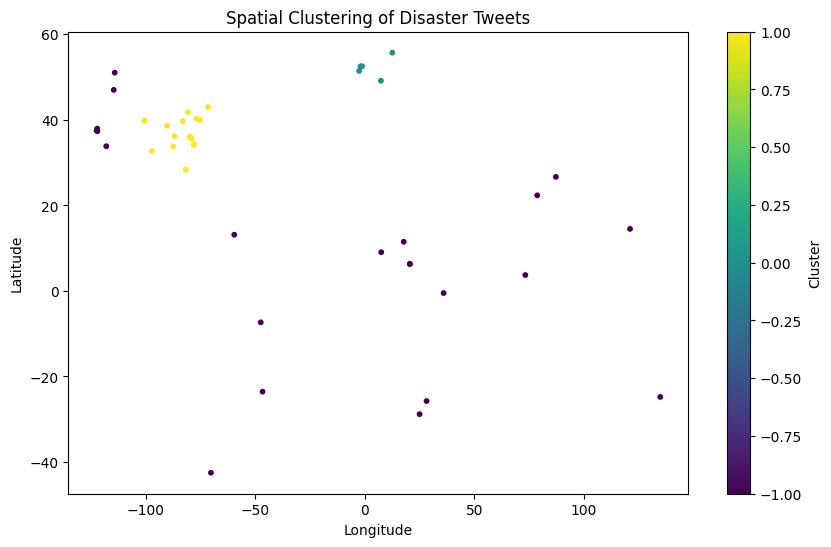

In [24]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import DoubleType
from opencage.geocoder import OpenCageGeocode
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Initialize Spark
spark = SparkSession.builder.appName("Geocoding").getOrCreate()

# Initialize OpenCage Geocoder
API_KEY = "eeb5797da3e944068c99c92df273961d"  # Replace with your actual key
geocoder = OpenCageGeocode(API_KEY)

# Define UDF for geocoding
def get_coordinates(location):
    try:
        if location:
            result = geocoder.geocode(location)
            if result:
                return (float(result[0]['geometry']['lat']), float(result[0]['geometry']['lng']))
    except Exception:
        pass
    return (None, None)

# Register UDF
get_coords_udf = udf(get_coordinates, "struct<lat:double,lon:double>")

# Apply geocoding to first 500 rows
geo_df = df.limit(100).withColumn("coords", get_coords_udf(col("location")))

# Extract latitude and longitude
geo_df = geo_df.select(
    "*",
    col("coords.lat").alias("latitude"),
    col("coords.lon").alias("longitude")
).drop("coords")

# Drop rows with missing coordinates
geo_df = geo_df.na.drop(subset=["latitude", "longitude"])

# Convert to Pandas for clustering (only if dataset is small)
pdf = geo_df.select("latitude", "longitude").toPandas()

# Standardize coordinates
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(pdf[['latitude', 'longitude']])

# Apply DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5)
pdf['cluster'] = dbscan.fit_predict(coords_scaled)

# Plot clusters
plt.figure(figsize=(10, 6))
plt.scatter(pdf['longitude'], pdf['latitude'], c=pdf['cluster'], cmap='viridis', s=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Clustering of Disaster Tweets')
plt.colorbar(label='Cluster')
plt.show()

In [25]:
from sklearn.cluster import DBSCAN
import numpy as np

# Convert PySpark DataFrame to Pandas
geo_pd_df = geo_df.toPandas()

# Ensure no missing values in latitude and longitude
geo_pd_df = geo_pd_df.dropna(subset=['latitude', 'longitude'])

# Run DBSCAN clustering (assuming you haven't assigned clusters yet)
dbscan = DBSCAN(eps=0.3, min_samples=5)
geo_pd_df['cluster'] = dbscan.fit_predict(geo_pd_df[['latitude', 'longitude']])

# Now try plotting
import folium

# Create a Folium world map
m = folium.Map(location=[20, 0], zoom_start=2)

# Define colors for clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightblue']

# Add cluster markers to the map
for _, row in geo_pd_df.iterrows():
    cluster_id = row['cluster']
    color = colors[cluster_id % len(colors)] if cluster_id != -1 else "gray"

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Cluster {cluster_id}"
    ).add_to(m)

# Show the map
m


In [26]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# Initialize Spark Session
spark = SparkSession.builder.appName("ML_Pipeline").getOrCreate()

# Drop null values in text and target columns
df = df.dropna(subset=["text", "target"])

# Convert target column to integer
df = df.withColumn("target", df["target"].cast(IntegerType()))

# Define text cleaning function
def clean_text(text):
    if text is None:
        return ""
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)  # Remove numbers
    return text

# Convert function to PySpark UDF
clean_text_udf = udf(clean_text, StringType())

# Apply UDF to create a new cleaned text column
df = df.withColumn("clean_text", clean_text_udf(df["text"]))

# Convert Spark DataFrame to Pandas for ML processing
pdf = df.select("clean_text", "target").toPandas().dropna()

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(pdf["clean_text"], pdf["target"], test_size=0.2, random_state=42)

# Build ML Pipeline
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train Model
pipeline.fit(X_train, y_train)

# Predictions
y_pred = pipeline.predict(X_test)

# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2f}")
print(report)


25/04/02 18:47:36 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Model Accuracy: 0.78
              precision    recall  f1-score   support

           0       0.75      0.91      0.82       781
           1       0.86      0.63      0.73       655

    accuracy                           0.78      1436
   macro avg       0.80      0.77      0.77      1436
weighted avg       0.80      0.78      0.78      1436



25/04/02 18:48:02 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Calculating text similarity...
Building similarity graph...
Calculating outlier scores...
Generating visualizations...


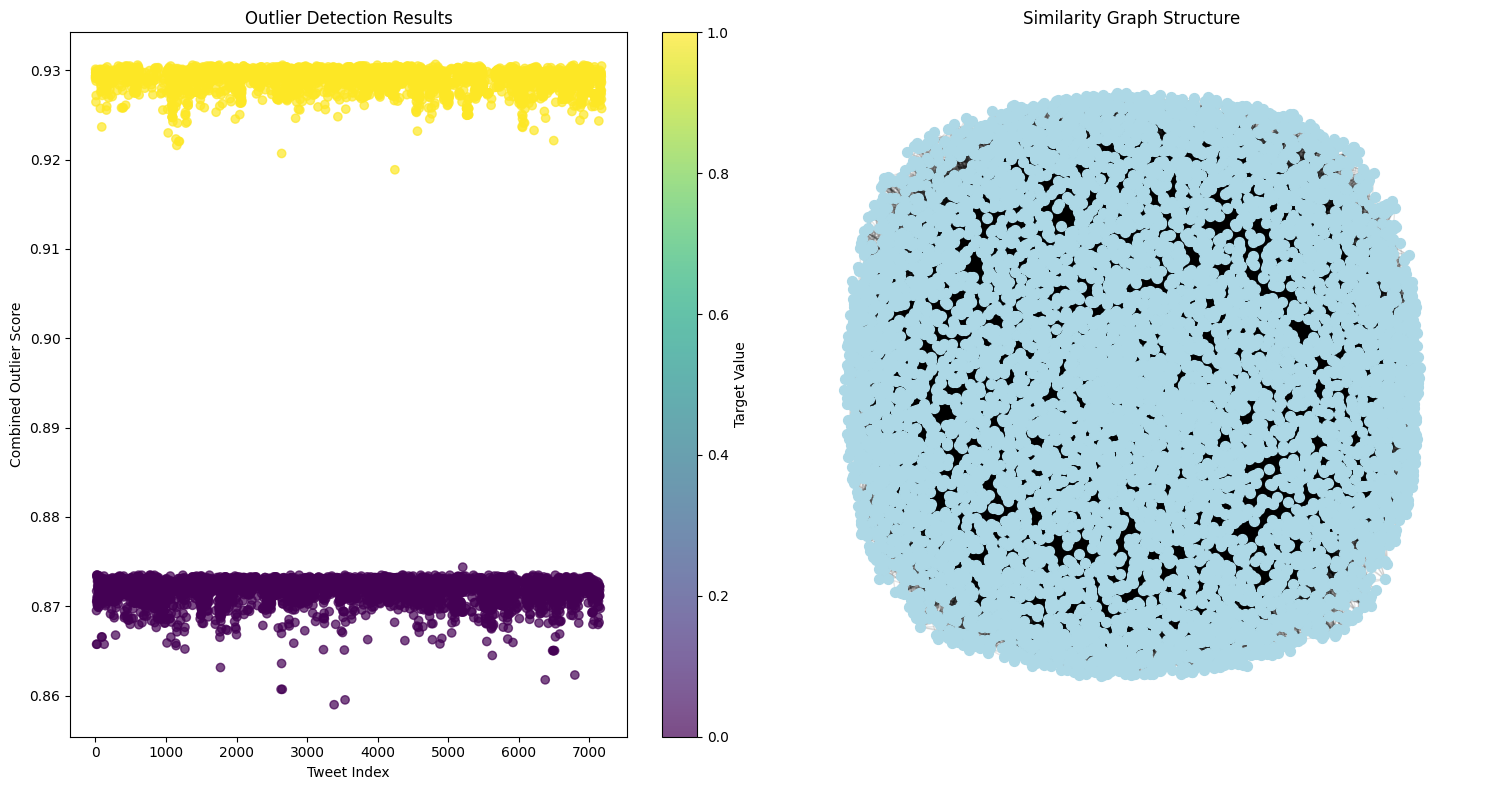


=== Results Summary ===
Identified 7176 nodes and 73816 edges
Similarity threshold used: 0.2000
Average degree centrality: 0.0029
Average betweenness centrality: 0.0004

Top 10 Potential Outliers:
   id                                                                                                                              clean_text  target  combined_outlier_score
 7306                                                    us navy sidelines  newest subs   defensenewscomus navy sidelines  newest subsd  navy       1                0.930663
  905 stationcdrkelly any support sys  usagov auth taken hostage by blk us clergyforced  exist youngerampgrossly disfigured by bioterrorismap       1                0.930581
 2089                                                      rt greenharvard documenting climate changes first major casualty  via greenharvard       1                0.930574
 2657                                                                                                     

In [27]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import zscore
import matplotlib.pyplot as plt

# Initialize Spark Session
spark = SparkSession.builder.appName("EnhancedOutlierDetection").getOrCreate()

# Load data with correct column names
pandas_data = df.select("id", "clean_text", "target").toPandas()

# 1. Enhanced Text Similarity Analysis
print("Calculating text similarity...")
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(pandas_data['clean_text'])
similarity_matrix = cosine_similarity(tfidf_matrix)

# 2. Graph Construction with Adaptive Threshold
print("Building similarity graph...")
mean_sim_value = np.mean(similarity_matrix)  # This is already a numpy float
# Use np.maximum instead of max to avoid PySpark interception
threshold = np.maximum(0.2, mean_sim_value * 1.5)  # Dynamic threshold

G = nx.Graph()
for idx, row in pandas_data.iterrows():
    G.add_node(row['id'], text=row['clean_text'], target=row['target'])

for i in range(len(pandas_data)):
    for j in range(i+1, len(pandas_data)):
        if similarity_matrix[i,j] > threshold:
            G.add_edge(pandas_data.iloc[i]['id'], pandas_data.iloc[j]['id'], 
                      weight=similarity_matrix[i,j])

# 3. Enhanced Outlier Detection
print("Calculating outlier scores...")
# Graph-based metrics
degree_centrality = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G, weight='weight')  # Use edge weights

# Calculate combined outlier score
pandas_data['graph_outlier_score'] = pandas_data['id'].apply(
    lambda x: 0 if x not in degree_centrality else 
    (1 - degree_centrality[x]) * (1 + betweenness.get(x, 0))
)

# Statistical analysis of target values
pandas_data['target_zscore'] = zscore(pandas_data['target'])
pandas_data['target_iqr'] = 0  # Initialize
Q1, Q3 = np.percentile(pandas_data['target'], [25, 75])
IQR = Q3 - Q1
if IQR > 0:  # Only calculate if there's variation
    pandas_data['target_iqr'] = (
        (pandas_data['target'] < (Q1 - 1.5*IQR)) | 
        (pandas_data['target'] > (Q3 + 1.5*IQR))
    ).astype(int)

# Combine metrics into final outlier score
pandas_data['combined_outlier_score'] = (
    pandas_data['graph_outlier_score'] * 0.7 + 
    pandas_data['target_zscore'].abs() * 0.2 +
    pandas_data['target_iqr'] * 0.1
)

# 4. Visualization
print("Generating visualizations...")
plt.figure(figsize=(15, 8))

# Plot 1: Outlier scores
plt.subplot(1, 2, 1)
plt.scatter(
    range(len(pandas_data)),
    pandas_data['combined_outlier_score'],
    c=pandas_data['target'],
    cmap='viridis',
    alpha=0.7
)
plt.colorbar(label='Target Value')
plt.xlabel('Tweet Index')
plt.ylabel('Combined Outlier Score')
plt.title('Outlier Detection Results')

# Plot 2: Graph visualization (simplified)
plt.subplot(1, 2, 2)
pos = nx.spring_layout(G, k=0.15, iterations=20)
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='lightblue')
nx.draw_networkx_edges(G, pos, alpha=0.1)
plt.title('Similarity Graph Structure')
plt.axis('off')

plt.tight_layout()
plt.show()

# 5. Results Analysis
print("\n=== Results Summary ===")
print(f"Identified {len(G.nodes())} nodes and {len(G.edges())} edges")
print(f"Similarity threshold used: {threshold:.4f}")
print(f"Average degree centrality: {np.mean(list(degree_centrality.values())):.4f}")
print(f"Average betweenness centrality: {np.mean(list(betweenness.values())):.4f}")

# Get top outliers
top_outliers = pandas_data.nlargest(10, 'combined_outlier_score')[['id', 'clean_text', 'target', 'combined_outlier_score']]
print("\nTop 10 Potential Outliers:")
print(top_outliers.to_string(index=False))

In [30]:
df

DataFrame[id: string, keyword: string, location: string, text: string, target: int, length: int, clean_text: string]

In [33]:
pandas_df = df.toPandas()
# Create dummy timestamps (sequential hours)
pandas_df['timestamp'] = pd.date_range(start='2023-01-01', periods=len(pandas_df), freq='H')
anomalies_df = detect_keyword_spikes(pandas_df['text'], pandas_df['timestamp'])
anomalies_df

,keyword,time,z_score,count
0,help,2023-01-03 19:00:00,6.381339,1.0
1,help,2023-01-03 20:00:00,6.381339,1.0
2,help,2023-01-04 20:00:00,6.381339,1.0
3,help,2023-01-04 21:00:00,6.381339,1.0
4,help,2023-01-11 03:00:00,6.381339,1.0
...,...,...,...,...
1518,danger,2023-06-19 06:00:00,7.204228,1.0
1519,danger,2023-08-03 05:00:00,7.204228,1.0
1520,danger,2023-08-03 06:00:00,7.204228,1.0
1521,danger,2023-10-09 00:00:00,7.204228,1.0



Detected anomalies:
     keyword                time    z_score  count
1383     sos 2023-03-29 08:00:00  34.568772    1.0
1384     sos 2023-03-29 09:00:00  34.568772    1.0
1385     sos 2023-05-11 07:00:00  34.568772    1.0
1386     sos 2023-05-11 08:00:00  34.568772    1.0
1387     sos 2023-09-02 04:00:00  34.568772    1.0
1388     sos 2023-09-02 05:00:00  34.568772    1.0
1196  urgent 2023-04-20 14:00:00  29.933259    1.0
1194  urgent 2023-02-16 22:00:00  29.933259    1.0
1201  urgent 2023-07-09 21:00:00  29.933259    1.0
1200  urgent 2023-07-09 20:00:00  29.933259    1.0

Disaster Topics Identified:
   topic_id                                          top_terms
0         0  [like, im, just, body, suicide, new, storm, at...
1         1  [amp, just, people, im, like, disaster, mass, ...
2         2  [news, emergency, time, just, california, buil...

Sentiment Analysis Results:


+----------------------------------------------------------------------------------------------------------------------------------+-----------+----------+---------------+
|text                                                                                                                              |vader_score|blob_score|distress_signal|
+----------------------------------------------------------------------------------------------------------------------------------+-----------+----------+---------------+
|our deeds are the reason of this earthquake may allah forgive us all                                                              |0.2732     |0.0       |NULL           |
|forest fire near la ronge sask canada                                                                                             |-0.34      |0.1       |NULL           |
|all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected|-0.296  

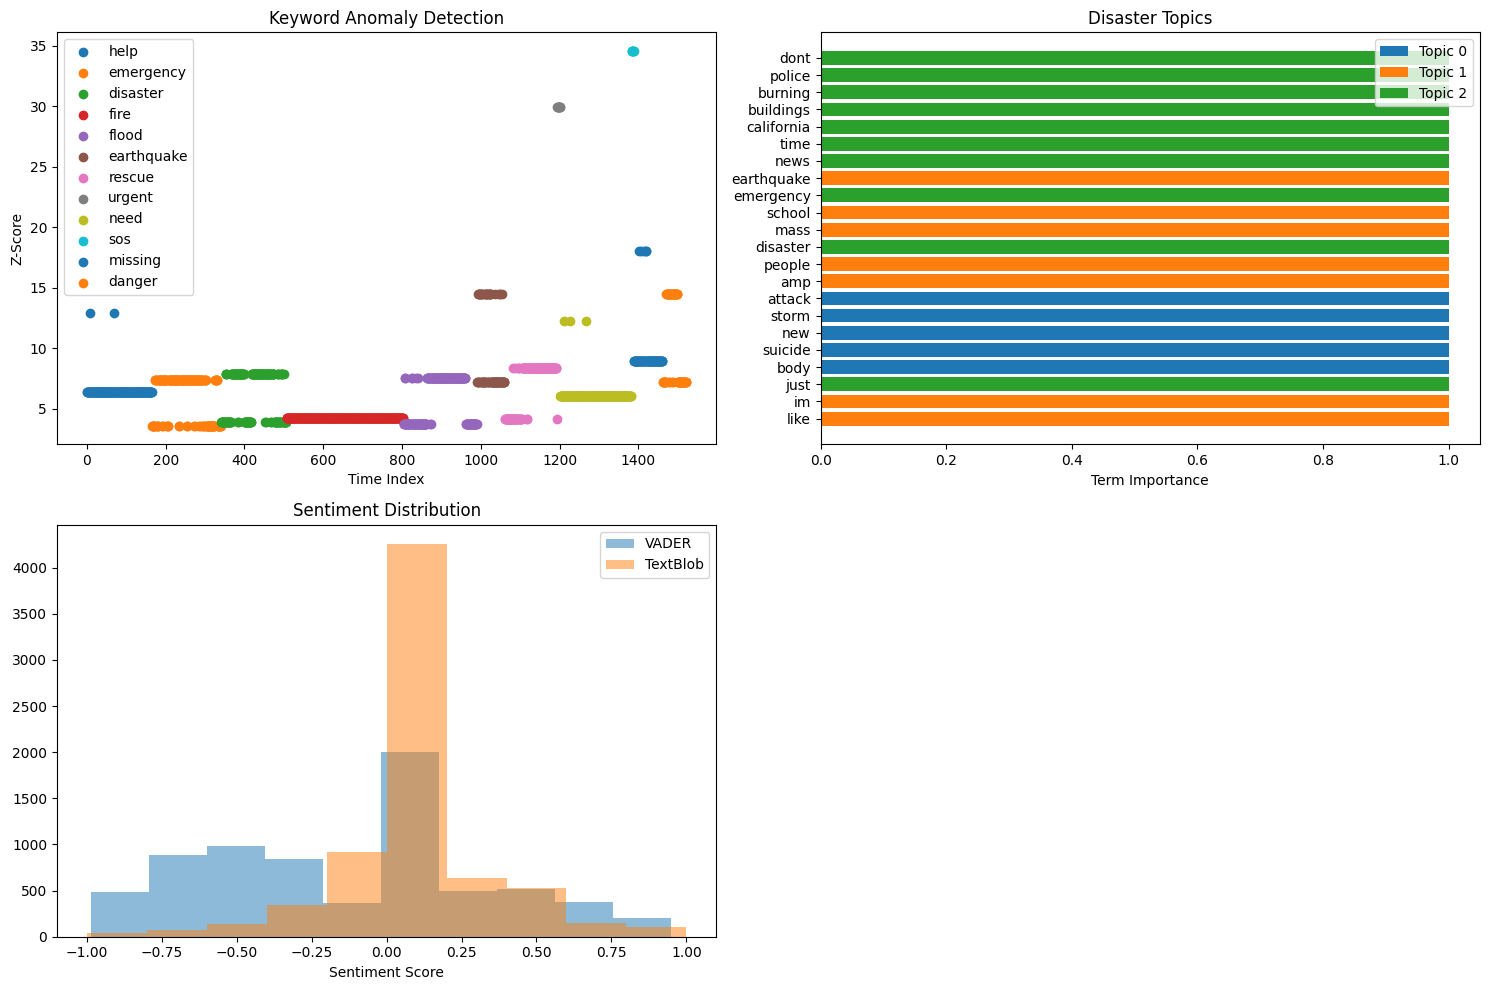


Note: No severity labels found - classification model not trained


In [34]:
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import FloatType, StringType, ArrayType
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from scipy import stats
from collections import defaultdict

# Try to import sentiment analysis packages with fallbacks
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    vader_available = True
except ImportError:
    vader_available = False
    print("VADER sentiment not available - using TextBlob only")

try:
    from textblob import TextBlob
    textblob_available = True
except ImportError:
    textblob_available = False
    print("TextBlob not available - sentiment analysis disabled")

# Initialize Spark
spark = SparkSession.builder.appName("DisasterDetection").getOrCreate()

# Load data (example - replace with your data loading code)
# df = spark.read.json("tweets.json")
# For testing, let's create a small sample DataFrame
#data = [("1", "Help needed! Flood in downtown area", "2023-01-01 12:00:00"),
        #("2", "Fire reported in the industrial district", "2023-01-01 12:05:00"),
        #("3", "Casual weather update for the weekend", "2023-01-01 12:10:00")]
#df = spark.createDataFrame(data, ["id", "text", "timestamp"])


# 1. Anomaly Detection via Keyword Frequency Spikes
def detect_keyword_spikes(text_series, timestamps, window_size=2, z_threshold=3):
    keywords = ['help', 'emergency', 'disaster', 'fire', 'flood', 'earthquake', 
                'rescue', 'urgent', 'need', 'sos', 'missing', 'danger']
    
    # Create a DataFrame with timestamps
    df = pd.DataFrame({'text': text_series, 'timestamp': pd.to_datetime(timestamps)})
    df = df.set_index('timestamp').sort_index()
    
    keyword_counts = defaultdict(list)
    
    for kw in keywords:
        df[kw] = df['text'].str.contains(kw, case=False, na=False).astype(int)
        df[kw + '_count'] = df[kw].rolling(window=window_size, min_periods=1).sum()

    anomalies = []
    for kw in keywords:
        counts = df[kw + '_count'].dropna()
        if len(counts) < 2:  # Avoid zero-division error
            continue
        
        z_scores = np.abs(stats.zscore(counts))
        spike_indices = np.where(z_scores > z_threshold)[0]

        for idx in spike_indices:
            anomalies.append({
                'keyword': kw,
                'time': counts.index[idx],
                'z_score': z_scores[idx],
                'count': counts.iloc[idx]
            })
    
    anomalies_df = pd.DataFrame(anomalies)
    return anomalies_df

# Use corrected function
anomalies_df = detect_keyword_spikes(pandas_df['text'], pandas_df['timestamp'])

# Check if anomalies exist before sorting
if not anomalies_df.empty and 'z_score' in anomalies_df.columns:
    print("\nDetected anomalies:")
    print(anomalies_df.sort_values('z_score', ascending=False).head(10))
else:
    print("\nNo anomalies detected.")

# 2. Topic Modeling with LDA
def perform_topic_modeling(texts, n_topics=3):
    vectorizer = CountVectorizer(max_df=0.95, min_df=1, stop_words='english')
    tf = vectorizer.fit_transform(texts.fillna(""))
    
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(tf)
    
    feature_names = vectorizer.get_feature_names_out()
    topics = []
    for topic_idx, topic in enumerate(lda.components_):
        topics.append({
            "topic_id": topic_idx,
            "top_terms": [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
        })
    
    return pd.DataFrame(topics), lda.transform(tf)

topics_df, topic_scores = perform_topic_modeling(pandas_df['text'])
print("\nDisaster Topics Identified:")
print(topics_df)

# 3. Sentiment Analysis with fallbacks
def analyze_sentiment(text):
    distress_signals = 0
    distress_phrases = ["help needed", "urgent assistance", "sos", "rescue needed"]
    
    # Check for distress signals
    if isinstance(text, str):
        text_lower = text.lower()
        distress_signals = int(any(phrase in text_lower for phrase in distress_phrases))
    
    # Initialize default scores
    vader_score = 0.0
    blob_score = 0.0
    
    # Calculate VADER score if available
    if vader_available and isinstance(text, str):
        vader_score = SentimentIntensityAnalyzer().polarity_scores(text)['compound']
    
    # Calculate TextBlob score if available
    if textblob_available and isinstance(text, str):
        blob_score = TextBlob(text).sentiment.polarity
    
    return [float(vader_score), float(blob_score), int(distress_signals)]

# Add sentiment analysis to DataFrame
sentiment_udf = udf(analyze_sentiment, ArrayType(FloatType()))
df = df.withColumn("sentiment", sentiment_udf(col("text")))
df = df.withColumn("vader_score", col("sentiment")[0])
df = df.withColumn("blob_score", col("sentiment")[1])
df = df.withColumn("distress_signal", col("sentiment")[2])

# Show results
print("\nSentiment Analysis Results:")
df.select("text", "vader_score", "blob_score", "distress_signal").show(truncate=False)

# 4. Visualization
plt.figure(figsize=(15, 10))

# Plot 1: Anomaly detection (placeholder - would need temporal data)
plt.subplot(2, 2, 1)
if not anomalies_df.empty:
    for kw in anomalies_df['keyword'].unique():
        subset = anomalies_df[anomalies_df['keyword'] == kw]
        plt.scatter(subset.index, subset['z_score'], label=kw)
    plt.title('Keyword Anomaly Detection')
    plt.xlabel('Time Index')
    plt.ylabel('Z-Score')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'No anomalies detected', ha='center')

# Plot 2: Topic modeling
plt.subplot(2, 2, 2)
for i, row in topics_df.iterrows():
    plt.barh(row['top_terms'], [1]*len(row['top_terms']), label=f"Topic {i}")
plt.title('Disaster Topics')
plt.xlabel('Term Importance')
plt.legend()

# Plot 3: Sentiment distribution
plt.subplot(2, 2, 3)
if vader_available:
    plt.hist(df.select("vader_score").toPandas(), bins=10, alpha=0.5, label='VADER')
if textblob_available:
    plt.hist(df.select("blob_score").toPandas(), bins=10, alpha=0.5, label='TextBlob')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.legend()

plt.tight_layout()
plt.show()

# For classification, you would need labeled data
# This is just a placeholder structure
if 'severity_label' in df.columns:
    from pyspark.ml.feature import VectorAssembler
    from pyspark.ml.classification import RandomForestClassifier
    from pyspark.ml.pipeline import Pipeline
    
    feature_cols = ["vader_score", "blob_score", "distress_signal"]
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    rf = RandomForestClassifier(labelCol="severity_label", featuresCol="features")
    pipeline = Pipeline(stages=[assembler, rf])
    # model = pipeline.fit(df)
else:
    print("\nNote: No severity labels found - classification model not trained")

In [35]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.pipeline import Pipeline



columns = ["text", "vader_score", "blob_score", "distress_signal"]


# Fill missing values to prevent errors
df = df.fillna({"vader_score": 0.0, "blob_score": 0.0, "distress_signal": 0})

# Define Severity Label
df = df.withColumn(
    "severity_label",
    when((col("distress_signal") == 1) | (col("vader_score") < -0.5), 2)  # High severity
    .when((col("vader_score") < 0) | (col("blob_score") < 0), 1)  # Medium severity
    .otherwise(0)  # Low severity
)

df.select("text", "vader_score", "blob_score", "distress_signal", "severity_label").show(truncate=False)

# Feature Vector Assembler
feature_cols = ["vader_score", "blob_score", "distress_signal"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="keep")

# Random Forest Classifier
rf = RandomForestClassifier(labelCol="severity_label", featuresCol="features", numTrees=10)

# Create Pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Train/Test Split
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Train Model
model = pipeline.fit(train_df)

# Predictions
predictions = model.transform(test_df)

# Evaluate Accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="severity_label", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"\nModel Accuracy: {accuracy:.2f}")

# Show Predictions
predictions.select("text", "severity_label", "prediction").show(truncate=False)



+----------------------------------------------------------------------------------------------------------------------------------+-----------+----------+---------------+--------------+
|text                                                                                                                              |vader_score|blob_score|distress_signal|severity_label|
+----------------------------------------------------------------------------------------------------------------------------------+-----------+----------+---------------+--------------+
|our deeds are the reason of this earthquake may allah forgive us all                                                              |0.2732     |0.0       |0.0            |0             |
|forest fire near la ronge sask canada                                                                                             |-0.34      |0.1       |0.0            |1             |
|all residents asked to shelter in place are being notified by of


Model Accuracy: 0.99


[Stage 101:>                                                        (0 + 1) / 1]

+-----------------------------------------------------------------------------------------------------------------------------------------------+--------------+----------+
|text                                                                                                                                           |severity_label|prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------------+--------------+----------+
| had a personalinjury accident this summer read our advice amp see how a solicitor can help otleyhour                                          |1             |1.0       |
|greenlacey godslove amp thanku my sister for rt of new video  the coming apocalyptic us earthquake amp tsunami                                 |2             |2.0       |
|erictsunami worry about yourself                                                                                                           

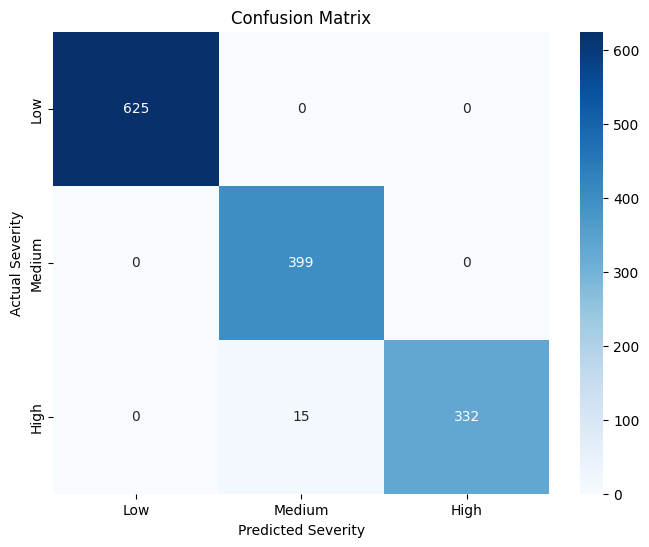

In [37]:
from pyspark.mllib.evaluation import MulticlassMetrics
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert predictions and labels to float type
predictionAndLabels = predictions.select(
    col("prediction").cast("float"), 
    col("severity_label").cast("float")
).rdd

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='g', 
            xticklabels=['Low', 'Medium', 'High'], 
            yticklabels=['Low', 'Medium', 'High'],
            cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Severity')
plt.ylabel('Actual Severity')
plt.show()

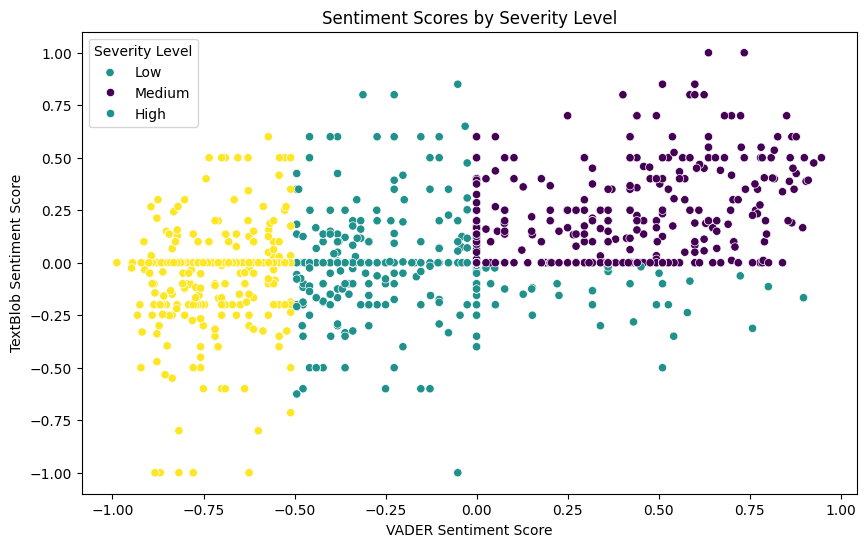

In [39]:
# Convert to pandas for easier plotting
plot_df = predictions.select("vader_score", "blob_score", "severity_label").toPandas()

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x="vader_score", y="blob_score", 
                hue="severity_label", palette="viridis")
plt.title('Sentiment Scores by Severity Level')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('TextBlob Sentiment Score')
plt.legend(title='Severity Level', labels=['Low', 'Medium', 'High'])
plt.show()

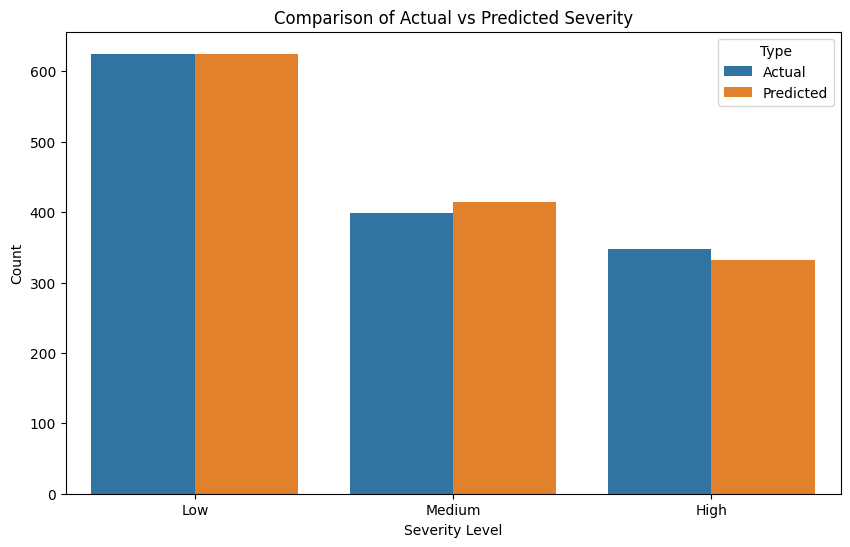

In [38]:
comparison_df = predictions.select("severity_label", "prediction").toPandas()

plt.figure(figsize=(10, 6))
sns.countplot(data=comparison_df.melt(), x='value', hue='variable',
             palette={'severity_label': '#1f77b4', 'prediction': '#ff7f0e'})
plt.title('Comparison of Actual vs Predicted Severity')
plt.xlabel('Severity Level')
plt.ylabel('Count')
plt.legend(title='Type', labels=['Actual', 'Predicted'])
plt.xticks([0, 1, 2], ['Low', 'Medium', 'High'])
plt.show()

In [41]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, struct, when
from pyspark.sql.types import StringType, FloatType
import pandas as pd
import numpy as np

# Initialize Spark (if not already done)
spark = SparkSession.builder.appName("DisasterSeverity").getOrCreate()

# 1. Enhanced Severity Scoring Function
def calculate_severity_score(row):
    """Calculate comprehensive severity score combining multiple factors"""
    # Base weights (adjust based on your domain knowledge)
    weights = {
        'keyword_urgency': 0.35,
        'sentiment': 0.3,
        'distress_terms': 0.25,
        'repetition': 0.1
    }
    
    # 1. Keyword urgency analysis
    urgent_keywords = ['emergency', 'urgent', 'critical', 'immediate', 'help']
    keyword_score = sum(1 for kw in urgent_keywords if kw in row['text'].lower()) / len(urgent_keywords)
    
    # 2. Sentiment analysis (using existing vader_score)
    sentiment_score = 1 - row['vader_score']  # More negative = more severe
    
    # 3. Distress term detection
    distress_terms = ['sos', 'rescue', 'trapped', 'danger', 'evacuate']
    distress_score = sum(1 for term in distress_terms if term in row['text'].lower()) / len(distress_terms)
    
    # 4. Message repetition (if you have user/source info)
    repetition_score = 0  # Could be enhanced with groupBy user/location
    
    # Calculate composite score
    composite_score = (
        weights['keyword_urgency'] * keyword_score +
        weights['sentiment'] * sentiment_score +
        weights['distress_terms'] * distress_score +
        weights['repetition'] * repetition_score
    )
    
    return float(composite_score)

# Register UDF
severity_score_udf = udf(calculate_severity_score, FloatType())

# 2. Generate Severity Labels
# Calculate severity scores - FIXED: Added struct import and proper column reference
df = df.withColumn("severity_score", severity_score_udf(struct([col(c) for c in df.columns])))

# Define severity thresholds (adjust based on your data distribution)
df = df.withColumn("severity_label",
                  when(col("severity_score") >= 0.75, "critical")
                  .when(col("severity_score") >= 0.45, "severe")
                  .otherwise("minor"))

# Show distribution
print("Severity Label Distribution:")
df.groupBy("severity_label").count().orderBy("count", ascending=False).show()

25/04/02 19:44:50 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Severity Label Distribution:


[Stage 110:>                                                        (0 + 1) / 1]

+--------------+-----+
|severity_label|count|
+--------------+-----+
|         minor| 5210|
|        severe| 1966|
+--------------+-----+



In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
import re
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Initialize Spark Session
spark = SparkSession.builder.appName("TweetAnalysis").getOrCreate()

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Load dataset from HDFS
#df = spark.read.csv("hdfs://master-node:9000/user/dinesh/tweets_data_sample/bda_train.csv", 
                     #header=True, 
                     #inferSchema=True)

# Handle missing values
df = df.na.fill("", subset=["keyword"])
df = df.na.fill("Unknown", subset=["location"])

# Initialize NLP tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Function to clean text
def clean_text(text):
    if text is None:
        return ""
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+|#\w+", "", text)  # Remove mentions/hashtags
    text = re.sub(r"[^\w\s]", "", text)  # Remove special characters
    text = emoji.replace_emoji(text, replace="")  # Remove emojis
    return text

# Function to preprocess text
def preprocess_text(text):
    if text is None:
        return ""
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [stemmer.stem(word) for word in words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(words)

# ✅ Register UDFs **BEFORE** using them
clean_text_udf = udf(clean_text, StringType())
preprocess_text_udf = udf(preprocess_text, StringType())

# ✅ Apply transformations correctly
df = df.withColumn("cleaned_text", preprocess_text_udf(clean_text_udf(col("text"))))

# Show results
df.show(truncate=False)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/surendra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/surendra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/surendra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[Stage 4:>                                                          (0 + 1) / 1]

+---+-------+--------+-------------------------------------------------------------------------------------------------------------------------------------+------+------------------------------------------------------------------------------+
|id |keyword|location|text                                                                                                                                 |target|cleaned_text                                                                  |
+---+-------+--------+-------------------------------------------------------------------------------------------------------------------------------------+------+------------------------------------------------------------------------------+
|1  |       |Unknown |Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all                                                                |1     |deed reason may allah forgiv u                                                |
|4  |       |Unknown |Forest

25/04/02 14:11:13 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
INFO:backoff:Backing off _opencage_request(...) for 0.5s (requests.exceptions.ConnectionError: HTTPSConnectionPool(host='api.opencagedata.com', port=443): Max retries exceeded with url: /geocode/v1/json?q=Birmingham&key=eeb5797da3e944068c99c92df273961d (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7fa81dc85820>: Failed to resolve 'api.opencagedata.com' ([Errno -3] Temporary failure in name resolution)")))


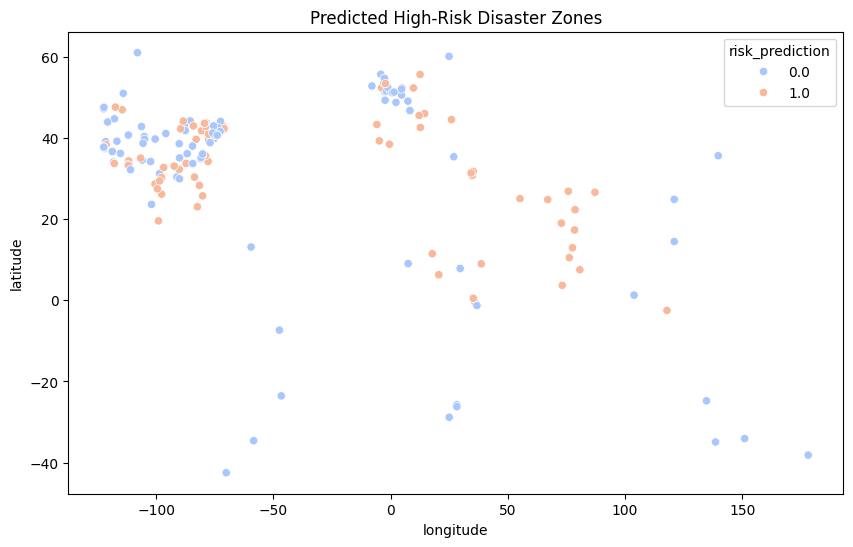

In [83]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np

# Initialize Spark Session
spark = SparkSession.builder.appName("SpatialPrediction").getOrCreate()
# Load dataset
df = spark.read.csv("hdfs://master-node:9000/user/dinesh/tweets_data_sample/bda_train.csv", 
                    header=True, inferSchema=True)

# Add geocoded coordinates (reusing your geocoding logic)
from opencage.geocoder import OpenCageGeocode
API_KEY = "eeb5797da3e944068c99c92df273961d"  # Replace with your API key
geocoder = OpenCageGeocode(API_KEY)

def get_coordinates(location):
    try:
        if pd.notna(location) and isinstance(location, str):
            result = geocoder.geocode(location)
            if result and len(result) > 0:
                return result[0]['geometry']['lat'], result[0]['geometry']['lng']
    except:
        return None, None
    return None, None

# Convert to Pandas for ML
pdf = df.limit(500).toPandas()  # Limiting to 500 rows to avoid API overuse
pdf[['latitude', 'longitude']] = pdf['location'].apply(lambda x: pd.Series(get_coordinates(x)))

# Drop rows with missing coordinates or target
pdf = pdf.dropna(subset=['latitude', 'longitude', 'target'])

# Features: latitude, longitude, and target (disaster or not)
X = pdf[['latitude', 'longitude']]
y = pdf['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf_model.predict(X_test)
#print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
#print(classification_report(y_test, y_pred))

# Predict high-risk zones (example: entire dataset)
pdf['risk_prediction'] = rf_model.predict(X)

# Visualize predictions
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', hue='risk_prediction', data=pdf, palette='coolwarm')
plt.title("Predicted High-Risk Disaster Zones")
plt.show()

In [52]:
# Initialize Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("DisasterDashboard").getOrCreate()

# ========== DATA PREPARATION ==========
# Assuming df is your loaded Spark DataFrame with columns:
# ['id', 'keyword', 'location', 'text', 'target', 'length', 'clean_text', 'vader_score', 'blob_score', 'distress_signal', 'severity_score', 'severity_label']

# Add dummy latitude/longitude if not present (for mapping)
if 'lat' not in df.columns or 'lon' not in df.columns:
    from pyspark.sql.functions import rand
    df = df.withColumn('lat', rand() * 180 - 90)  # Random latitudes between -90 and 90
    df = df.withColumn('lon', rand() * 360 - 180)  # Random longitudes between -180 and 180

# Register temp view for SQL queries
df.createOrReplaceTempView("disaster_data")

# ========== INTERACTIVE WIDGETS ==========
import ipywidgets as widgets
from IPython.display import display, HTML
import pandas as pd

# Create interactive filters
location_options = ['All'] + sorted([row['location'] for row in df.select("location").distinct().collect() if row['location']])
location_filter = widgets.Dropdown(
    options=location_options,
    description='Location:',
    style={'description_width': 'initial'}
)

severity_options = ['All'] + sorted([row['severity_label'] for row in df.select("severity_label").distinct().collect() if row['severity_label']])
severity_filter = widgets.Dropdown(
    options=severity_options,
    description='Severity:',
    style={'description_width': 'initial'}
)

keyword_search = widgets.Text(
    description='Keyword:',
    style={'description_width': 'initial'}
)

# ========== VISUALIZATION FUNCTIONS ==========
import plotly.express as px
import folium
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Create output areas
out_map = widgets.Output()
out_stats = widgets.Output()
out_wordcloud = widgets.Output()

def update_dashboard(change):
    # Build SQL query based on filters
    query = "SELECT * FROM disaster_data WHERE 1=1"
    
    if location_filter.value != 'All':
        query += f" AND location = '{location_filter.value}'"
    if severity_filter.value != 'All':
        query += f" AND severity_label = '{severity_filter.value}'"
    if keyword_search.value:
        query += f" AND (LOWER(text) LIKE LOWER('%{keyword_search.value}%') OR LOWER(clean_text) LIKE LOWER('%{keyword_search.value}%'))"
    
    filtered_df = spark.sql(query)
    
    # Check if data exists
    if filtered_df.count() == 0:
        with out_map:
            display(HTML("<p style='color:red'>No data matching filters</p>"))
        with out_stats:
            display(HTML("<p style='color:red'>No data matching filters</p>"))
        with out_wordcloud:
            display(HTML("<p style='color:red'>No data matching filters</p>"))
        return
    
    pdf = filtered_df.toPandas()
    
    # Clear previous outputs
    out_map.clear_output()
    out_stats.clear_output()
    out_wordcloud.clear_output()
    
    # 1. Update Map Visualization
    with out_map:
        try:
            # Calculate center point
            center_lat = pdf['lat'].mean()
            center_lon = pdf['lon'].mean()
            
            m = folium.Map(location=[center_lat, center_lon], zoom_start=6)
            
            # Add markers
            for _, row in pdf.iterrows():
                folium.CircleMarker(
                    location=[row['lat'], row['lon']],
                    radius=row['severity_score']*10 + 5,  # Scale for visibility
                    color='red' if row['severity_score'] > 0.7 else 'orange' if row['severity_score'] > 0.4 else 'green',
                    fill=True,
                    fill_opacity=0.7,
                    popup=folium.Popup(f"""
                        <b>{row.get('keyword', 'N/A')}</b><br>
                        Location: {row.get('location', 'N/A')}<br>
                        Severity: {row.get('severity_label', 'N/A')}<br>
                        Score: {row.get('severity_score', 0):.2f}<br>
                        <hr>
                        {row.get('text', 'No text')[:100]}...
                        """, max_width=300)
                ).add_to(m)
            
            display(m)
        except Exception as e:
            display(HTML(f"<p style='color:red'>Error generating map: {str(e)}</p>"))
    
    # 2. Update Statistical Visualizations
    with out_stats:
        try:
            # Sentiment Distribution
            fig1 = px.histogram(pdf, x='vader_score', color='severity_label',
                              title='Sentiment Distribution by Severity',
                              nbins=20,
                              labels={'vader_score': 'Sentiment Score', 'severity_label': 'Severity'})
            
            # Severity Distribution
            severity_counts = pdf['severity_label'].value_counts().reset_index()
            severity_counts.columns = ['severity_label', 'count']
            fig2 = px.pie(severity_counts, values='count', names='severity_label',
                         title='Severity Level Distribution')
            
            # Display plots side by side
            display(widgets.HBox([fig1, fig2]))
        except Exception as e:
            display(HTML(f"<p style='color:red'>Error generating stats: {str(e)}</p>"))
    
    # 3. Update Word Cloud
    with out_wordcloud:
        try:
            if 'clean_text' in pdf.columns:
                stop_words = set(stopwords.words('english'))
                custom_stopwords = ['http', 'https', 'com', 'www']  # Add domain-specific stopwords
                text = ' '.join(pdf['clean_text'].dropna().astype(str))
                
                if text.strip():
                    wc = WordCloud(width=800, height=400, 
                                 background_color='white', 
                                 stopwords=stop_words.union(custom_stopwords),
                                 collocations=False)
                    wc.generate(text)
                    
                    plt.figure(figsize=(12, 6))
                    plt.imshow(wc, interpolation='bilinear')
                    plt.axis("off")
                    plt.title("Most Frequent Words in Filtered Reports")
                    plt.show()
                else:
                    display(HTML("<p>No text data available for word cloud</p>"))
            else:
                display(HTML("<p>No clean_text column available</p>"))
        except Exception as e:
            display(HTML(f"<p style='color:red'>Error generating word cloud: {str(e)}</p>"))

# ========== DASHBOARD LAYOUT ==========
# Set up observer for filters
for widget in [location_filter, severity_filter, keyword_search]:
    widget.observe(update_dashboard, names='value')

# Display the dashboard
display(HTML("""
<style>
    .widget-label { min-width: 120px !important; }
    .widget-dropdown { min-width: 200px !important; }
    .widget-text { min-width: 300px !important; }
</style>
<h1 style='text-align:center; color:#e74c3c;'>🌍 Disaster Monitoring Dashboard</h1>
"""))

# Create filter row
filter_row = widgets.HBox([
    widgets.VBox([location_filter]),
    widgets.VBox([severity_filter]),
    widgets.VBox([keyword_search])
])

# Main layout
dashboard = widgets.VBox([
    filter_row,
    widgets.HTML("<hr>"),
    widgets.HTML("<h3 style='text-align:center'>Geographical Distribution</h3>"),
    out_map,
    widgets.HTML("<hr>"),
    widgets.HTML("<h3 style='text-align:center'>Statistical Analysis</h3>"),
    out_stats,
    widgets.HTML("<hr>"),
    widgets.HTML("<h3 style='text-align:center'>Text Analysis</h3>"),
    out_wordcloud
])

display(dashboard)

# Initial render
update_dashboard(None)

In [ ]:
# Initialize Spark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("DisasterDashboard").getOrCreate()

# ========== DATA PREPARATION ==========
# Assuming df is your loaded Spark DataFrame with columns:
# ['id', 'keyword', 'location', 'text', 'target', 'length', 'clean_text', 'vader_score', 'blob_score', 'distress_signal', 'severity_score', 'severity_label']

# Add dummy latitude/longitude if not present (for mapping)
if 'lat' not in df.columns or 'lon' not in df.columns:
    from pyspark.sql.functions import rand
    df = df.withColumn('lat', rand() * 180 - 90)  # Random latitudes between -90 and 90
    df = df.withColumn('lon', rand() * 360 - 180)  # Random longitudes between -180 and 180

# Register temp view for SQL queries
df.createOrReplaceTempView("disaster_data")

# ========== INTERACTIVE WIDGETS ==========
import ipywidgets as widgets
from IPython.display import display, HTML
import pandas as pd

# Create interactive filters
location_options = ['All'] + sorted([row['location'] for row in df.select("location").distinct().collect() if row['location']])
location_filter = widgets.Dropdown(
    options=location_options,
    description='Location:',
    style={'description_width': 'initial'}
)

severity_options = ['All'] + sorted([row['severity_label'] for row in df.select("severity_label").distinct().collect() if row['severity_label']])
severity_filter = widgets.Dropdown(
    options=severity_options,
    description='Severity:',
    style={'description_width': 'initial'}
)

keyword_search = widgets.Text(
    description='Keyword:',
    style={'description_width': 'initial'}
)

# ========== VISUALIZATION FUNCTIONS ==========
import plotly.express as px
import folium
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

# Create output areas
out_map = widgets.Output()
out_stats = widgets.Output()
out_wordcloud = widgets.Output()

def update_dashboard(change):
    # Build SQL query based on filters
    query = "SELECT * FROM disaster_data WHERE 1=1"
    
    if location_filter.value != 'All':
        query += f" AND location = '{location_filter.value}'"
    if severity_filter.value != 'All':
        query += f" AND severity_label = '{severity_filter.value}'"
    if keyword_search.value:
        query += f" AND (LOWER(text) LIKE LOWER('%{keyword_search.value}%') OR LOWER(clean_text) LIKE LOWER('%{keyword_search.value}%'))"
    
    filtered_df = spark.sql(query)
    
    # Check if data exists
    if filtered_df.count() == 0:
        with out_map:
            display(HTML("<p style='color:red'>No data matching filters</p>"))
        with out_stats:
            display(HTML("<p style='color:red'>No data matching filters</p>"))
        with out_wordcloud:
            display(HTML("<p style='color:red'>No data matching filters</p>"))
        return
    
    pdf = filtered_df.toPandas()
    
    # Clear previous outputs
    out_map.clear_output()
    out_stats.clear_output()
    out_wordcloud.clear_output()
    
    # 1. Update Map Visualization
    with out_map:
        try:
            # Calculate center point
            center_lat = pdf['lat'].mean()
            center_lon = pdf['lon'].mean()
            
            m = folium.Map(location=[center_lat, center_lon], zoom_start=6)
            
            # Add markers
            for _, row in pdf.iterrows():
                folium.CircleMarker(
                    location=[row['lat'], row['lon']],
                    radius=row['severity_score']*10 + 5,  # Scale for visibility
                    color='red' if row['severity_score'] > 0.7 else 'orange' if row['severity_score'] > 0.4 else 'green',
                    fill=True,
                    fill_opacity=0.7,
                    popup=folium.Popup(f"""
                        <b>{row.get('keyword', 'N/A')}</b><br>
                        Location: {row.get('location', 'N/A')}<br>
                        Severity: {row.get('severity_label', 'N/A')}<br>
                        Score: {row.get('severity_score', 0):.2f}<br>
                        <hr>
                        {row.get('text', 'No text')[:100]}...
                        """, max_width=300)
                ).add_to(m)
            
            display(m)
        except Exception as e:
            display(HTML(f"<p style='color:red'>Error generating map: {str(e)}</p>"))
    
    # 2. Update Statistical Visualizations
    with out_stats:
        try:
            # Sentiment Distribution
            fig1 = px.histogram(pdf, x='vader_score', color='severity_label',
                              title='Sentiment Distribution by Severity',
                              nbins=20,
                              labels={'vader_score': 'Sentiment Score', 'severity_label': 'Severity'})
            
            # Severity Distribution
            severity_counts = pdf['severity_label'].value_counts().reset_index()
            severity_counts.columns = ['severity_label', 'count']
            fig2 = px.pie(severity_counts, values='count', names='severity_label',
                         title='Severity Level Distribution')
            
            # Display plots side by side
            display(widgets.HBox([fig1, fig2]))
        except Exception as e:
            display(HTML(f"<p style='color:red'>Error generating stats: {str(e)}</p>"))
    
    # 3. Update Word Cloud
    with out_wordcloud:
        try:
            if 'clean_text' in pdf.columns:
                stop_words = set(stopwords.words('english'))
                custom_stopwords = ['http', 'https', 'com', 'www']  # Add domain-specific stopwords
                text = ' '.join(pdf['clean_text'].dropna().astype(str))
                
                if text.strip():
                    wc = WordCloud(width=800, height=400, 
                                 background_color='white', 
                                 stopwords=stop_words.union(custom_stopwords),
                                 collocations=False)
                    wc.generate(text)
                    
                    plt.figure(figsize=(12, 6))
                    plt.imshow(wc, interpolation='bilinear')
                    plt.axis("off")
                    plt.title("Most Frequent Words in Filtered Reports")
                    plt.show()
                else:
                    display(HTML("<p>No text data available for word cloud</p>"))
            else:
                display(HTML("<p>No clean_text column available</p>"))
        except Exception as e:
            display(HTML(f"<p style='color:red'>Error generating word cloud: {str(e)}</p>"))

# ========== DASHBOARD LAYOUT ==========
# Set up observer for filters
for widget in [location_filter, severity_filter, keyword_search]:
    widget.observe(update_dashboard, names='value')

# Display the dashboard
display(HTML("""
<style>
    .widget-label { min-width: 120px !important; }
    .widget-dropdown { min-width: 200px !important; }
    .widget-text { min-width: 300px !important; }
</style>
<h1 style='text-align:center; color:#e74c3c;'>🌍 Disaster Monitoring Dashboard</h1>
"""))

# Create filter row
filter_row = widgets.HBox([
    widgets.VBox([location_filter]),
    widgets.VBox([severity_filter]),
    widgets.VBox([keyword_search])
])

# Main layout
dashboard = widgets.VBox([
    filter_row,
    widgets.HTML("<hr>"),
    widgets.HTML("<h3 style='text-align:center'>Geographical Distribution</h3>"),
    out_map,
    widgets.HTML("<hr>"),
    widgets.HTML("<h3 style='text-align:center'>Statistical Analysis</h3>"),
    out_stats,
    widgets.HTML("<hr>"),
    widgets.HTML("<h3 style='text-align:center'>Text Analysis</h3>"),
    out_wordcloud
])

display(dashboard)

# Initial render
update_dashboard(None)

[Stage 218:>                                                        (0 + 1) / 1]